# Vendredi 12 Avril 

## Logistic Regression
* Voir https://app.jedha.co/course/logistic-regression-course-ft/logistic-regression-ft


# Logistic regression with scikit-learn

Let's come back to our famous toy-dataset and change the objective : we would like to predict if a person will buy a product (variable "Purchased") as a function of the other variables. To do so, we'll train a logistic regression model and evaluate its performances.

## What will you learn in this course?

This lecture is a follow-along demo that will guide you through the steps of building logistic regressions models and evaluate them on actual data.

- Multivariate logistic regression
  - Training Pipeline
  - Test Pipeline


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    classification_report
)
import matplotlib.pyplot as plt
import warnings

# warnings.filterwarnings(
#     "ignore", category=DeprecationWarning
# )  # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=[
        "#4B9AC7",
        "#4BE8E0",
        "#9DD4F3",
        "#97FBF6",
        "#2A7FAF",
        "#23B1AB",
        "#0E3449",
        "#015955",
    ]
)
pio.templates.default = "jedha"
# pio.renderers.default = "svg"  # to be replaced by "iframe" if working on JULIE

In [2]:
# Import dataset
print("Loading dataset...")
dataset = pd.read_csv("../12_assets/05_supervised_ML/Data.csv")
print("...Done.")
print()

Loading dataset...
...Done.



In [3]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include="all")
display(data_desc)
print()

print("Percentage of missing values: ")
display(100 * dataset.isnull().sum() / dataset.shape[0])

Number of rows : 10

Display of dataset: 


,Country,Age,Salary,Purchased
0,France,44.0,72000,No
1,Spain,27.0,48000,Yes
2,Germany,30.0,54000,No
3,Spain,38.0,61000,No
4,Germany,40.0,69000,Yes



Basics statistics: 


,Country,Age,Salary,Purchased
count,10,9.000000,10.000000,10
unique,3,NaN,NaN,2
top,France,NaN,NaN,No
freq,4,NaN,NaN,5
mean,NaN,38.777778,64300.000000,NaN
std,NaN,7.693793,11681.419244,NaN
min,NaN,27.000000,48000.000000,NaN
25%,NaN,35.000000,55000.000000,NaN
50%,NaN,38.000000,64000.000000,NaN
75%,NaN,44.000000,71250.000000,NaN



Percentage of missing values: 


Country       0.0
Age          10.0
Salary        0.0
Purchased     0.0
dtype: float64

## EDA

The EDA that has been done in the previous lectures is still valid. As we're now willing to predict the value of _Purchased_ as a function of the other variables, it would also be interesting to display the distribution of the explanatory variables obtained for the different values of _Purchased_:


In [4]:
# Univariate analysis
# Distribution of each numeric variable
num_features = ["Age", "Salary"]
for f in num_features:
    fig = px.histogram(
        dataset, f, color="Purchased", facet_row="Purchased", histnorm="probability"
    )
    fig.show()

### Ci-dessus, on représente bien des probas. La somme vaut 100%

<Note type="tip" title="Good to know">

As the target variable (_Purchased_) is categorical, it's not possible to make a scatterplot or to compute a correlation coefficient to test the dependency between the features and the target. The figure above allows to get an hint about which feature carries useful information to predict Y: if the distribution is very different depending on the value of Y, then the variable might be a good predictor of the target!

</Note>


## Baseline model : simple logistic regression

Let's try a first basic model : simple logistic regression with only one feature (_Salary_).


In [5]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = ["Salary"]
target_variable = "Purchased"

X = dataset.loc[:, features_list]
Y = dataset.loc[:, target_variable]

print("...Done.")
print()

print("Y : ")
print(Y.head())
print()
print("X :")
print(X.head())

Separating labels from features...
...Done.

Y : 
0     No
1    Yes
2     No
3     No
4    Yes
Name: Purchased, dtype: object

X :
   Salary
0   72000
1   48000
2   54000
3   61000
4   69000


In [6]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



### Preprocessing

<Note type="note" title="Simplified syntax">

In this first example, we don't need to use the classes `Pipeline` and `ColumnTransformer` because the preprocessing on the features X is very simple : it just consists in standardizing the variable _Salary_ (there are no missing values in this column). In this case, we can just create an instance of `StandardScaler` and call the `fit_transform` and `transform` methods directly on it, by passing X_train/X_test as argument.

We'll also make a label encoding on the target Y_train/Y_test, because it's categorical this time 🤓

</Note>


In [7]:
print("Preprocessing X_train...")
print(X_train.head())
print()
preprocessor = StandardScaler()
X_train = preprocessor.fit_transform(X_train)
print("...Done!")
print(X_train[0:5, :])  # X_train is now a numpy array
print()

# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder() # remplace Yes No en 0 1
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

Preprocessing X_train...
   Salary
4   69000
9   67000
1   48000
6   52000
7   79000

...Done!
[[ 0.58858382]
 [ 0.38385901]
 [-1.56102665]
 [-1.15157703]
 [ 1.61220785]]

Encoding labels...
4    Yes
9    Yes
1    Yes
6     No
7    Yes
Name: Purchased, dtype: object
...Done
[1 1 1 0 1]


In [8]:
# Test pipeline
print("Preprocessing X_test...")
print(X_test.head())
print()
X_test = preprocessor.transform(X_test)
print("...Done!")
print(X_test[0:5, :])  # X_test is now a numpy array
print()

# Label encoding
print("Encoding labels...")
print(Y_test.head())
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Preprocessing X_test...
   Salary
2   54000
8   83000

...Done!
[[-0.94685223]
 [ 2.02165746]]

Encoding labels...
2    No
8    No
Name: Purchased, dtype: object
...Done
[0 0]


### Train model


In [9]:
# Train model
print("Train model...")
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# voir weight et elasticnet
# fonctionne en classification binaire ou multiple
# Si 3 classes (voir note de cours)
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


### Performance assessment


In [10]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = classifier.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[1 1 1 1 1 1 1 1]

Probabilities on training set...
...Done.
[[0.35110617 0.64889383]
 [0.35905381 0.64094619]
 [0.43788384 0.56211616]
 [0.42087822 0.57912178]
 [0.3126592  0.6873408 ]
 [0.38335037 0.61664963]
 [0.339339   0.660661  ]
 [0.39572955 0.60427045]]



In [11]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = classifier.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[1 1]

Probabilities on test set...
...Done.
[[0.41244271 0.58755729]
 [0.29793914 0.70206086]]



### Ci-dessus 70% d'etre 1

In [12]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.625
accuracy on test set :  0.0

f1-score on training set :  0.7692307692307693
f1-score on test set :  0.0



### Perf equilibrées entre test et test

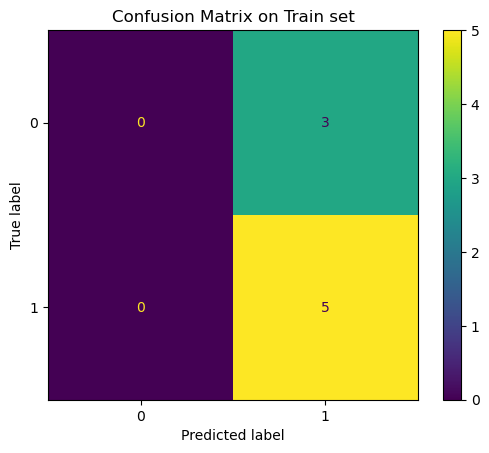

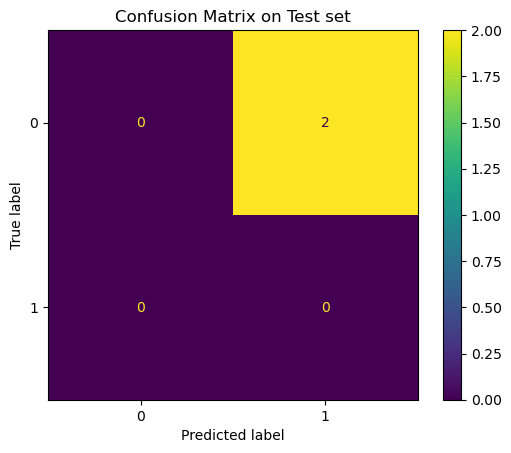

In [13]:
# Visualize confusion matrices
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    classifier, X_train, Y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    classifier, X_test, Y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

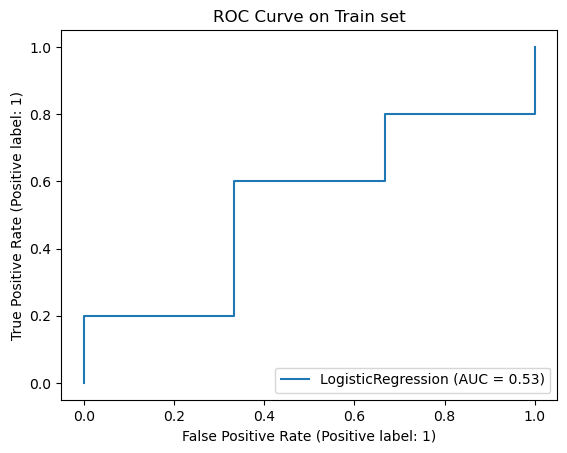

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



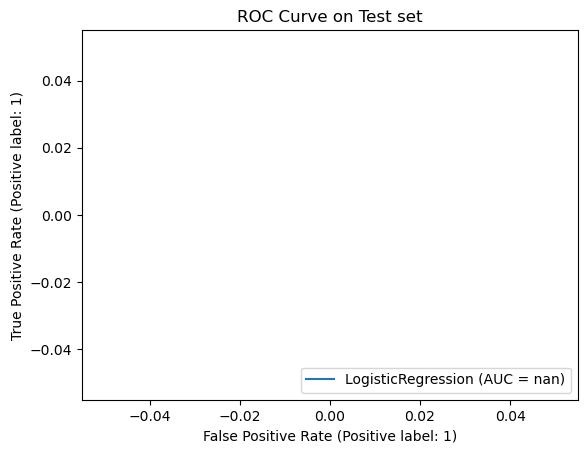

In [14]:
# Visualize ROC curves
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    classifier, X_train, Y_train, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    classifier, X_test, Y_test, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

<Note type="note" title="Empty plot">
The plot above is empty because the ROC curve implies that we have examples belonging to the two classes (0 and 1). However, the test set is very small (there are only two examples) and it contains only 0s. This shouldn't occur while working on datasets with a sufficient number of examples 😌
</Note>


In [15]:
# Visualize the model
# Visualize predictions on training Set
fig = px.scatter(x=X_train.flatten().tolist(), y=Y_train, title="training set")
fig.add_trace(
    go.Scatter(x=X_train.flatten().tolist(), y=Y_train_pred, name="predictions")
)
fig.add_trace(
    go.Scatter(
        x=X_train.flatten().tolist(), y=Y_train_proba[:, 1], name="probabilities"
    )
)
fig.show()

In [16]:
# Visualize predictions on test Set
fig = px.scatter(x=X_test.flatten().tolist(), y=Y_test, title="test set")
fig.add_trace(
    go.Scatter(x=X_test.flatten().tolist(), y=Y_test_pred, name="predictions")
)
fig.add_trace(
    go.Scatter(x=X_test.flatten().tolist(), y=Y_test_proba[:, 1], name="probabilites")
)
fig.show()

In [17]:
classification_report(Y_train,Y_train_pred)

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         3\n           1       0.62      1.00      0.77         5\n\n    accuracy                           0.62         8\n   macro avg       0.31      0.50      0.38         8\nweighted avg       0.39      0.62      0.48         8\n'

In [18]:
print(type (classification_report(Y_train,Y_train_pred)))
print(classification_report(Y_train,Y_train_pred))

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<class 'str'>
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.62      1.00      0.77         5

    accuracy                           0.62         8
   macro avg       0.31      0.50      0.38         8
weighted avg       0.39      0.62      0.48         8



c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in

In [19]:
print(classification_report(Y_test,Y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels wit

## Multivariate logistic regression

Let's train a multivariate model with 3 variables: `Age`, `Country` and `Salary`.


In [20]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "Purchased"

X = dataset.drop(target_variable, axis=1)
Y = dataset.loc[:, target_variable]

print("...Done.")
print()

print("Y : ")
print(Y.head())
print()
print("X :")
print(X.head())

Separating labels from features...
...Done.

Y : 
0     No
1    Yes
2     No
3     No
4    Yes
Name: Purchased, dtype: object

X :
   Country   Age  Salary
0   France  44.0   72000
1    Spain  27.0   48000
2  Germany  30.0   54000
3    Spain  38.0   61000
4  Germany  40.0   69000


In [21]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i, t in X.dtypes.items():
    if ("float" in str(t)) or ("int" in str(t)):
        numeric_features.append(i)
    else:
        categorical_features.append(i)

print("Found numeric features ", numeric_features)
print("Found categorical features ", categorical_features)

Found numeric features  ['Age', 'Salary']
Found categorical features  ['Country']


In [22]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0, stratify=Y
)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



### Preprocessing


In [23]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),  
        ("scaler", StandardScaler()),
    ]
)

In [24]:
# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(
    drop="first"
)  # no missing values in categorical data, so we only need the OHE

In [25]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [26]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print("...Done.")
print(
    X_train[0:5]
)  # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(
    X_test
)  # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print("...Done.")
print(
    X_test[0:5, :]
)  # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on train set...
   Country   Age  Salary
0   France  44.0   72000
4  Germany  40.0   69000
6    Spain   NaN   52000
9   France  37.0   67000
3    Spain  38.0   61000
...Done.
[[ 1.61706195e+00  1.46885753e+00  0.00000000e+00  0.00000000e+00]
 [ 8.22715727e-01  1.09777773e+00  1.00000000e+00  0.00000000e+00]
 [-1.41104234e-15 -1.00500778e+00  0.00000000e+00  1.00000000e+00]
 [ 2.26956063e-01  8.50391200e-01  0.00000000e+00  0.00000000e+00]
 [ 4.25542617e-01  1.08231607e-01  0.00000000e+00  1.00000000e+00]]

Encoding labels...
0     No
4    Yes
6     No
9    Yes
3     No
Name: Purchased, dtype: object
...Done
[0 1 0 1 0]
Performing preprocessings on test set...
   Country   Age  Salary
8  Germany  50.0   83000
7   France  48.0   79000
...Done.
[[2.80858127 2.82948345 1.         0.        ]
 [2.41140816 2.33471038 0.         0.        ]]

Encoding labels...
8     No
7    Yes
Name: Purchased, dtype: object
...Done
[0 1]


### Train model


In [27]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


### Performance assessment


In [28]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = classifier.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 1 0 1 1 1]

Probabilities on training set...
...Done.
[[0.55874347 0.44125653]
 [0.50914109 0.49085891]
 [0.62078895 0.37921105]
 [0.42785775 0.57214225]
 [0.5939559  0.4060441 ]
 [0.43566756 0.56433244]
 [0.39464843 0.60535157]
 [0.4592025  0.5407975 ]]



In [29]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = classifier.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0]

Probabilities on test set...
...Done.
[[0.63125494 0.36874506]
 [0.59511793 0.40488207]]



In [30]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.75
accuracy on test set :  0.5

f1-score on training set :  0.75
f1-score on test set :  0.0



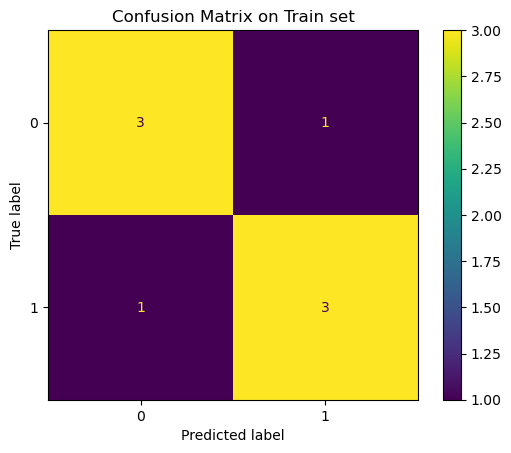

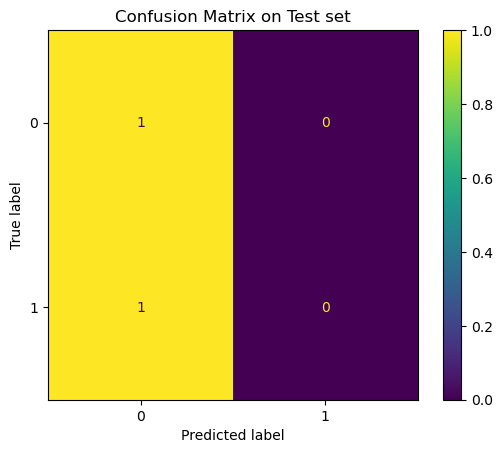

In [31]:
# Visualize confusion matrices
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    classifier, X_train, Y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    classifier, X_test, Y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

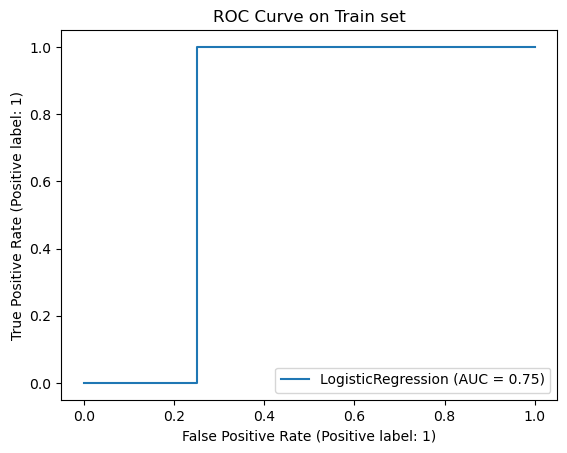

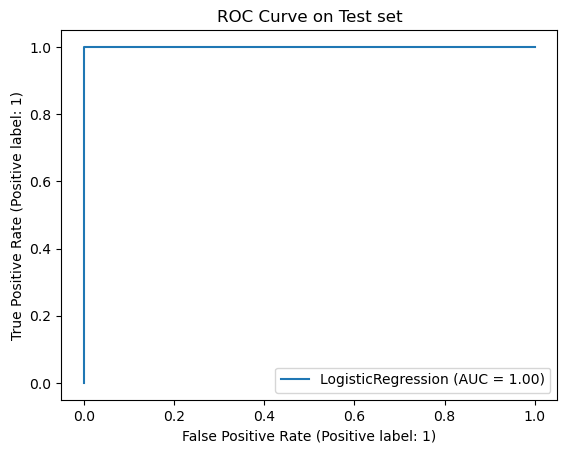

In [32]:
# Visualize ROC curves
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    classifier, X_train, Y_train, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    classifier, X_test, Y_test, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

## Resources 📚📚

- Update sklearn to version 1.0 - [https://bit.ly/2Csascr](https://scikit-learn.org/stable/install.html)
- Metrics and scoring: quantifying the quality of predictions - [https://bit.ly/0CSasrz](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
- ConfusionMatrixDisplay - [https://bit.ly/20SCsss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_estimator)
- RocCurveDisplay - [https://bit.ly/ZCsassZ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_predictions)


# En plus
pandas import circular dans le 

In [33]:
import sklearn
import sklearn.datasets
dataset = sklearn.datasets.make_circles(10000, noise=0.1)

In [34]:
dataset

(array([[ 0.77866148, -0.30903486],
        [-0.15222283, -0.78431673],
        [-1.09074164,  0.03717407],
        ...,
        [ 0.3189132 , -0.92487123],
        [ 0.40296185,  0.85288263],
        [ 0.19987075,  0.93035715]]),
 array([1, 1, 0, ..., 0, 0, 0], dtype=int64))

In [35]:
X, Y = dataset

In [36]:
px.scatter(x=X[:,0],y=X[:,1],color=Y)

In [37]:
# Model par cross validation pour séparer

import sklearn.feature_extraction
import sklearn.feature_selection
import sklearn.model_selection
import sklearn.preprocessing


pipe = Pipeline(steps=[
    ("poly",sklearn.preprocessing.PolynomialFeatures()),
    ("logit", LogisticRegression())
])

In [38]:
params = {
    "poly__degree" : [1,2,3],
    "logit__C" : [50,100,1000],
    "logit__penalty" : ["l2","None"]
}

grid = sklearn.model_selection.GridSearchCV(pipe, param_grid=params,cv=3)

grid.fit(X,Y)

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


27 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\sklearn\pipeline.py", l

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('logit', LogisticRegression())]),
             param_grid={'logit__C': [50, 100, 1000],
                         'logit__penalty': ['l2', 'None'],
                         'poly__degree': [1, 2, 3]})

In [39]:
grid.cv_results_

{'mean_fit_time': array([0.00977731, 0.03103042, 0.07052294, 0.00039045, 0.00061234,
        0.00145117, 0.00963775, 0.02572775, 0.0689462 , 0.00077438,
        0.00102067, 0.00089288, 0.0089732 , 0.01975799, 0.02669636,
        0.00104777, 0.00100358, 0.00110881]),
 'std_fit_time': array([1.46397037e-03, 6.72405096e-04, 8.56570544e-03, 4.31802939e-04,
        5.48242070e-04, 3.19144402e-04, 7.82144600e-04, 6.43867824e-03,
        1.80719765e-03, 5.49274599e-04, 4.10334006e-05, 6.50166926e-04,
        2.45697354e-03, 2.06719749e-03, 1.18927910e-03, 5.30545478e-05,
        1.52442949e-05, 1.61830005e-04]),
 'mean_score_time': array([0.00131138, 0.00106192, 0.00145388, 0.        , 0.        ,
        0.        , 0.00043758, 0.00109561, 0.00161632, 0.        ,
        0.        , 0.        , 0.00081809, 0.00103021, 0.00124232,
        0.        , 0.        , 0.        ]),
 'std_score_time': array([2.63351018e-04, 8.96893387e-05, 5.98331015e-04, 0.00000000e+00,
        0.00000000e+00, 0.00

In [40]:
grid.best_params_

{'logit__C': 50, 'logit__penalty': 'l2', 'poly__degree': 2}

In [41]:
grid.best_score_

0.8463990670212792